# BOSS Bright Sky - Using Spframe Flux

Using the BOSS sky spectra we can investigate the SNR calculations for the BGS survey on DESI. We want to confirm that we believe the model being used to determine exposure times for the bright time.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, glob, sys, fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
from astropy.io import fits
import pickle

import astropy.table
import astropy.units as u
from astropy.time import Time
import corner
import seaborn as sns

import sklearn.linear_model
import specsim.atmosphere
from scipy import interpolate
import statsmodels.api as sm 

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

In [3]:
# When you download the necessary files, change this directory
FILE_DIR = '/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/BGS_files/'

## Sky Continuum

According to the BGS wiki, the maximum number of targets have a redshift of $\approx$0.15. For the 4000 Ang then corresponds to $\approx$460nm. We can use BOSS sky spectra to study the sky brightness in the blue cameras. Below is a plot of the sky spectrum from the BOSS blue spectrograph with the moon up. I take the continuum level between 460-480nm and find the mean value of the continuum. I then take the mean continuum level for all sky fibers in a given image to analyze the dependence on parameters such as moon illumination and altitude.

I take the mean continuum level between 460 and 480 nm from the spframe sky flux files for each sky fiber and then take the mean of all sky fibers in a given observation. The flux ('SKY_VALUE') is saved with the metadata associated with that observation in 'good_data.fits'. 

NOTE: All units in this notebook are in $10^{-17} erg/cm^{2}/s/Ang.$

## DESI Simulated Sky Model

The following functions determine predicted sky level between 460-480nm from the DESI simulation sky model and add them to the fits table as 'MODEL_SKY'.

In [4]:
def opening_angle(ra1, dec1, ra2, dec2):
    # Compute the opening angles between (ra1,dec1) and (ra2,dec2)
    # in degrees using the Haversine formula.
    ra1, ra2 = np.deg2rad(ra1), np.deg2rad(ra2)
    dec1, dec2 = np.deg2rad(dec1), np.deg2rad(dec2)
    havRA12 = 0.5 * (1 - np.cos(ra2 - ra1))
    havDEC12 = 0.5 * (1 - np.cos(dec2 - dec1))
    havPHI = havDEC12 + np.cos(dec1) * np.cos(dec2) * havRA12
    return np.rad2deg(np.arccos(np.clip(1 - 2 * havPHI, -1, +1)))

In [5]:
def unitvec(ra, dec):
    # Return a unit vector aligned with (ra,dec) in degrees.
    ra, dec = np.deg2rad(ra), np.deg2rad(dec)
    cosdec = np.cos(dec)
    return np.array([cosdec * np.cos(ra), cosdec * np.sin(ra), np.sin(dec)])

In [6]:
def at_horizon(raz, decz, ra, dec):
    # Project (ra,dec) into the horizon plane defined by the zenith (raz,decz).
    # Invalid when (ra,dec) points along +/-zenith.
    z = unitvec(raz, decz)
    v = unitvec(ra, dec)
    dot = (z * v).sum(axis=0)
    assert np.all(dot < 1), '(ra,dec) points along +/-zenith'
    return (v - dot * z) / np.sqrt(1 - dot ** 2)

In [7]:
wavelength = np.linspace(3550, 9850, (9850-3550)*10)*u.Angstrom
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [64]:
DESIMODEL_DIR = os.getenv('DESIMODEL')

In [65]:
#moon spectrum
moon_s = np.loadtxt(FILE_DIR + 'solarspec.txt')
moon_s = interpolate.interp1d(moon_s[:,1], moon_s[:,2])
moon_spectrum = moon_s(wavelength)* u.erg/ (u.cm**2 * u.s * u.Angstrom)

#extinction curve
ext_c = np.loadtxt(FILE_DIR + 'ZenithExtinction-KPNO.dat')
ext_c = interpolate.interp1d(ext_c[:,0], ext_c[:,1])
extinction_coefficient = ext_c(wavelength)

#surface brightness
surf_bright = np.loadtxt(DESIMODEL_DIR + '/data/spectra/spec-sky.dat')
surf_bright = interpolate.interp1d(surf_bright[:,0], surf_bright[:,1])
surface_brightness_dict = {'dark':surf_bright(wavelength)*sky_unit}

In [9]:
def get_sky_model(data_line):
    """ Defines DESI sky model taken from specsim.atmosphere
    """
    airmass = data_line['AIRMASS']
    moon_zenith = data_line['MOON_ZENITH']*u.deg
    moon_sep = data_line['MOON_SEP']*u.deg
    moon_phase = data_line['MOON_ILL']
    seeing50 = data_line['SEEING50']*u.arcsec
    
    moon = specsim.atmosphere.Moon(wavelength, moon_spectrum, extinction_coefficient,
            airmass, moon_zenith, moon_sep, moon_phase)
    
    seeing = dict(fwhm_ref=seeing50,
                  wlen_ref=6335*u.Angstrom,
                  moffat_beta=float(3.5))
    
    atmosphere = specsim.atmosphere.Atmosphere(
        wavelength, surface_brightness_dict, extinction_coefficient,
        'yes', 'dark', airmass, seeing, moon)
    
    return atmosphere


In [66]:
def get_continuum(atm_model, line):
    """Measures sky continuum level in sky spectrum created from specsim
    """
    line_A = line*10
    upper, lower = (line_A+10, line_A - 10)
    sky = atm_model.surface_brightness.to(sky_unit)*area
    sky = sky.value
    wave = atm_model._wavelength.to(u.Angstrom).value
    idx = np.where((wave > lower)& (wave < upper))
    mean_sky_value = np.mean(sky[idx])
    
    return mean_sky_value

In [67]:
filen = FILE_DIR + '/good_mean_data_2018may04.fits'
data = astropy.table.Table.read(filen)

In [68]:
lines = pickle.load(open('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/BGS_files/line_file_updated.pkl','rb'))

In [69]:
band_waves = []
for cam, ll in lines.items():
    if (cam == 'b1') | (cam == 'r1'):
        for name, info in ll.items():
            if info[0] == 'cont':
                band_waves.append(info[1])

In [70]:
np.sort(band_waves)

array([ 380,  410,  425,  460,  480,  510,  540,  565,  583,  602,  615,
        642,  675,  710,  720,  740,  825,  833,  873,  920,  977, 1025])

In [71]:
def get_model_cont(data_table, band_lines = [480, 720]):
    """
    INPUT: - astropy.table.Table with meta data and cont measurements
           - line or lines you want to get the continuum for
    OUTPUT: copy of input astropy table with added model continuum values
    """
    for line in band_lines:
        cont_level = [get_continuum(get_sky_model(obs), line) for obs in data_table]
        data_table['MODEL_%d' % line] = astropy.table.Column(np.array(cont_level).astype(np.float32), unit=sky_unit)
        
    return data_table
data = get_model_cont(data)

## Defining 'Bright Sky'

The BGS survey will run on DESI when the sky brightness is $> 2.5$ times the brightness of the dark night sky. Grey time is defined as when the moon is above the horizon, but the sky brightness is less than 2.5 times the dark sky brightness. If we take a subset of data that is definitely dark, with airmass $\leq 1.4$, galactic latitude $> 10 ^{\circ}$, and both moon and sun altitude $<-18^{\circ}$, we can define the dark time mean sky brightness. 

In [72]:
def get_dark_data(data = data):
    dark_data = data[(data['AIRMASS']<1.4) & (data['SUN_ALT'] < -18) & (data['MOON_ALT']<-18)&(data["GAL_LAT"]>10)]
    return dark_data
dark_data = get_dark_data()

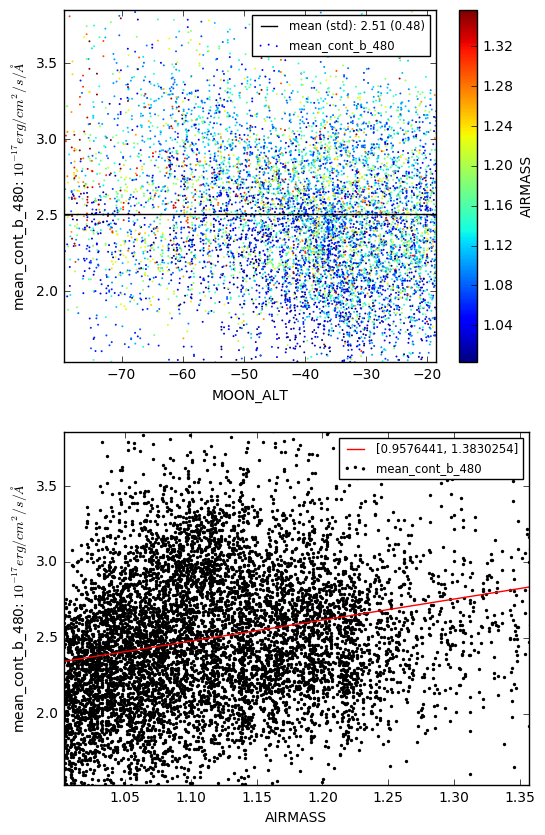

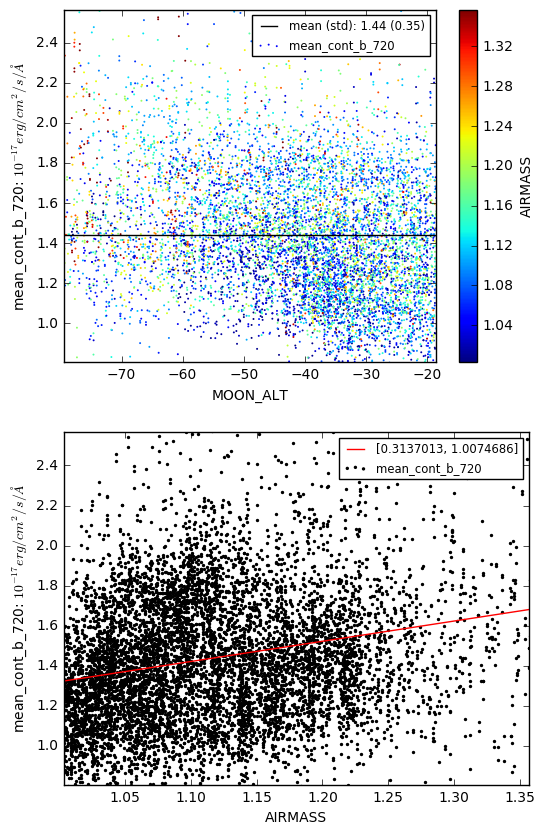

In [73]:
def dark_mean(line, data=dark_data, plot = True):
    if line < 650:
        data = data[(data['CAMERAS'] == 'b1')|(data['CAMERAS'] == 'b2')]
    elif line >= 650:
        data = data[(data['CAMERAS'] == 'r1')|(data['CAMERAS'] == 'r2')]
        
    yname = 'mean_cont_b_%d' %line
    xname='AIRMASS'
    vname='MOON_ALT'
    x = data[xname]
    y = data[yname]
    v = data[vname]

    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))
    
    if plot: 
        fig, ax = plt.subplots(2, 1, figsize=(6,10))
        ax = ax.flatten()

        s = ax[0].scatter(v, y, s=2, lw=0, c=x, vmin=xmin, vmax=xmax)
        plt.colorbar(s, ax=ax[0]).set_label(xname)
        ax[0].axhline(np.mean(y), color = 'k', label = "mean (std): %.2f (%.2f)" % (np.mean(y), np.std(y)))
        ax[0].set_xlim(vmin, vmax)
        ax[0].set_ylim(ymin, ymax)
        ax[0].set_xlabel(vname)
        ax[0].set_ylabel("%s: $10^{-17} erg/cm^{2}/s/\AA$" % yname)
        ax[0].legend(fontsize = 'small')

        #fit airmass dependence
        x_model = np.linspace(xmin, xmax, 50)
        model = sklearn.linear_model.LinearRegression(fit_intercept=False)
        getX = lambda x: np.vstack((1 + 0*x, x)).transpose()
        model.fit(getX(x), y)
        y_model = model.predict(getX(x_model))
        ax[1].scatter(x, y, s=2, color = 'k')
        ax[1].plot(x_model, y_model, 'r-', label = list(model.coef_))

        ax[1].set_xlim(xmin, xmax)
        ax[1].set_ylim(ymin, ymax)
        ax[1].set_xlabel(xname)
        ax[1].set_ylabel("%s: $10^{-17} erg/cm^{2}/s/\AA$" % yname)
        ax[1].legend(fontsize='small')
    
    mean = np.mean(y)
    return mean

dark_mean_b = dark_mean(480)
dark_mean_r = dark_mean(720)

Taking the dark sky brightness to be $2.5\times 10^{-17} erg/cm^{2}/s/$Ang @ 480nm and $1.4\times 10^{-17} erg/cm^{2}/s/$Ang @ 720nm, we can then define our gray and bright samples. Let's define it based on the blue value.

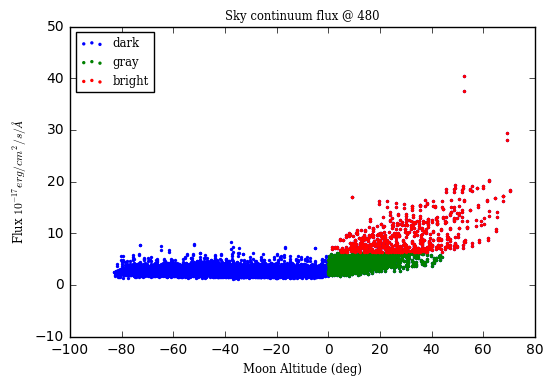

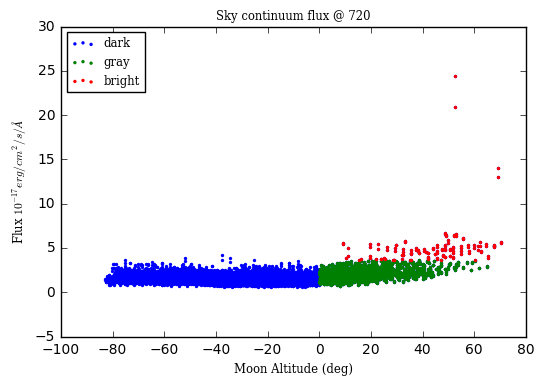

In [74]:
def make_data_dict(dark_mean, line, data = data, plot = False):
    if line < 650:
        data = data[(data['CAMERAS'] == 'b1')|(data['CAMERAS'] == 'b2')]
    elif line >= 650:
        data = data[(data['CAMERAS'] == 'r1')|(data['CAMERAS'] == 'r2')]
    sky_name = 'mean_cont_b_%d' % line
    gray_level = 2.5*dark_mean
    gray = np.where((data['MOON_ALT']>0)&(data[sky_name]<gray_level))
    bright = np.where((data['MOON_ALT']>0)&(data[sky_name]>gray_level))
    dark = get_dark_data()
        
    if plot:
        plt.figure()
        plt.scatter(data['MOON_ALT'], data[sky_name], s = 2, color = 'b', label = 'dark')
        plt.scatter(data['MOON_ALT'][gray], data[sky_name][gray], s = 2, color = 'g', label = 'gray')
        plt.scatter(data['MOON_ALT'][bright], data[sky_name][bright], s = 2, color = 'r', label = 'bright')
        plt.legend(loc='upper left', prop=font)
        plt.xlabel("Moon Altitude (deg)", fontproperties = font)
        plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
        plt.title("Sky continuum flux @ %d" % line, fontproperties = font)
     
    return {'good': data, 'gray': data[gray], 'bright': data[bright], 'dark': dark}

data_dict_b = make_data_dict(dark_mean_b, 480, plot=True)
data_dict_r = make_data_dict(dark_mean_r, 720, plot=True)

The brightness of the sky depends on Moon Altitude, but also considerably on the Moon illumination fraction

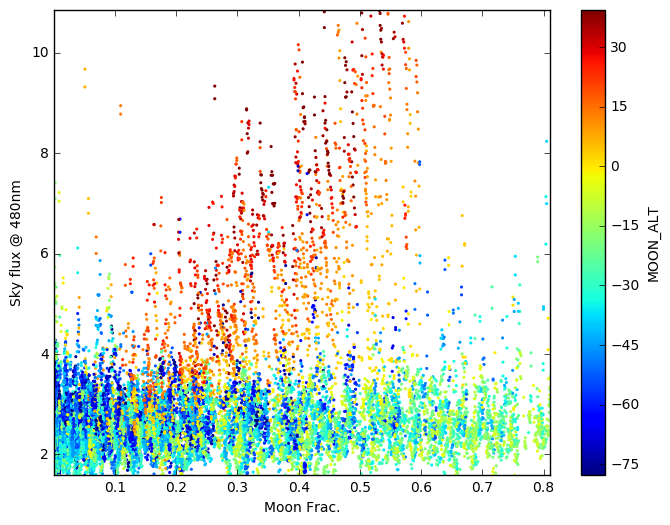

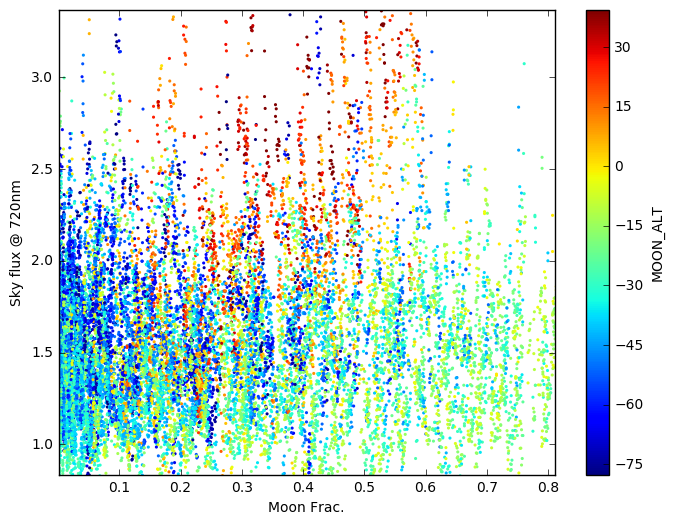

In [75]:
def moon_frac_plot(line, data):
    if line < 650:
        data = data[(data['CAMERAS'] == 'b1')|(data['CAMERAS'] == 'b2')]
    elif line >= 650:
        data = data[(data['CAMERAS'] == 'r1')|(data['CAMERAS'] == 'r2')]
        
    xname = 'MOON_ILL'
    yname='mean_cont_b_%d' % line
    vname='MOON_ALT'
    x = data[xname]
    y = data[yname]
    v = data[vname]

    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))

    mp = data['MOON_ILL']
    gsky = data[yname]
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    s = ax.scatter(x, y,
                      s=5, lw=0, c=v, vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax).set_label(vname)
    ax.set_xlim(np.percentile(mp, (1, 99)))
    ax.set_ylim(np.percentile(gsky, (1, 99)))
    ax.set_xlabel('Moon Frac.')
    ax.set_ylabel('Sky flux @ %dnm' % line)
    
moon_frac_plot(480,data_dict_b['good'])
moon_frac_plot(720,data_dict_r['good'])

## Comparing to Model Sky

In [98]:
def model_residuals(line, data, data_name):
    if line < 650:
        data = data[(data['CAMERAS'] == 'b1')|(data['CAMERAS'] == 'b2')]
    elif line >= 650:
        data = data[(data['CAMERAS'] == 'r1')|(data['CAMERAS'] == 'r2')]
        
    xname='MODEL_%d' % line
    vname='MOON_ALT'
    sky = data['mean_cont_b_%d' % line]
    model = data[xname]
    res = sky - model
    rms_y = np.std(sky)
    rms_res = np.std(res)

    x = data[xname]
    y = res
    v = data[vname]
    airmass = data['AIRMASS']
        
    # Calculate percentile limits.
    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

    s = ax1.scatter(x, sky/model, s=5, lw=0, c=v, vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax1).set_label(vname)
    ret = ax2.hist(res, bins = 25, label = 'data rms/res rms: %.2f' % (rms_y/float(rms_res)))

    ax1.set_xlim(xmin, xmax)
    ax1.set_xlabel(xname, fontproperties = font)
    ax1.set_ylabel('Measured/Model Sky', fontproperties = font)
    ax1.set_title("Residual plot for the %s sky model in $10^{-17} erg/cm^{2}/s/Ang$" % data_name, fontproperties = font)
    ax2.legend(loc = 'upper right')
    
    return res

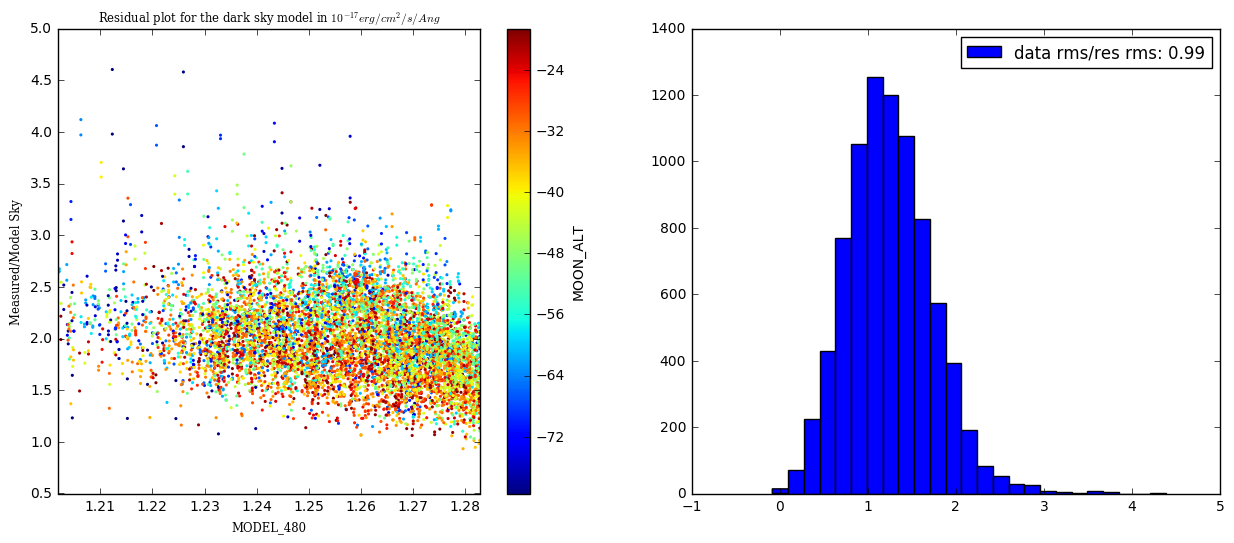

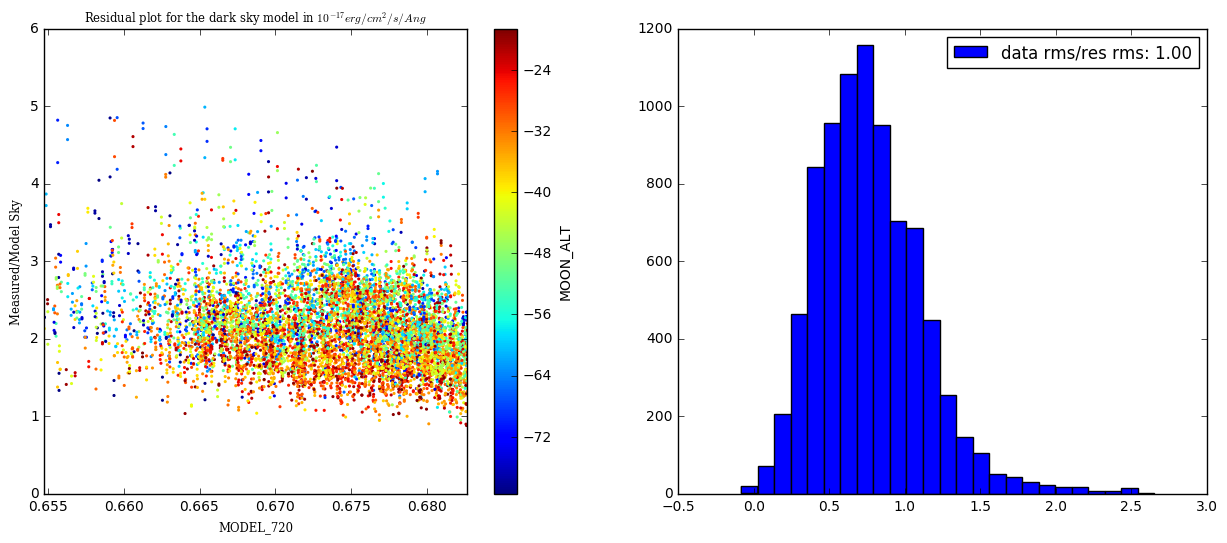

In [100]:
#This shows the dark sky model vs. measured flux. The agreement is good.
ret = model_residuals(480, data_dict_b['dark'],'dark')
ret = model_residuals(720, data_dict_r['dark'],'dark')

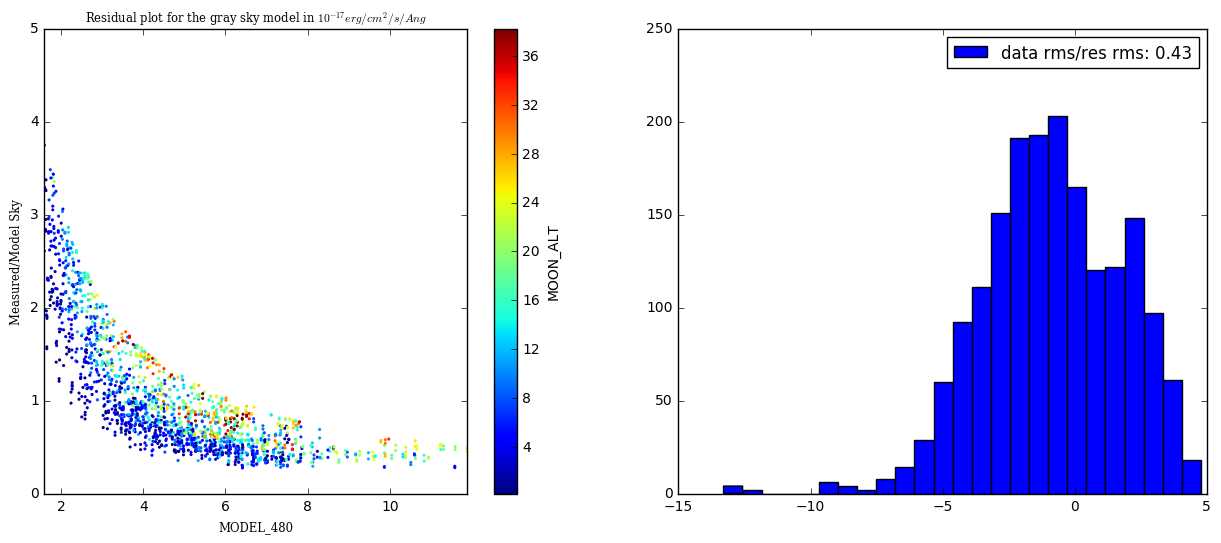

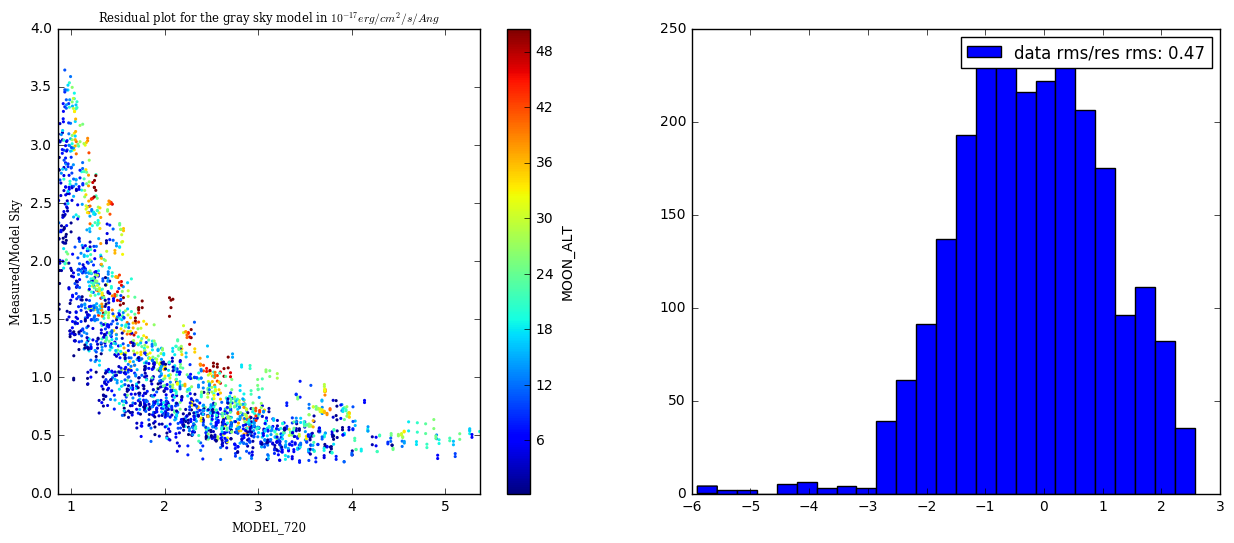

In [102]:
gray_res_b = model_residuals(480, data_dict_b['gray'],'gray')
gray_res_r = model_residuals(720, data_dict_r['gray'],'gray')

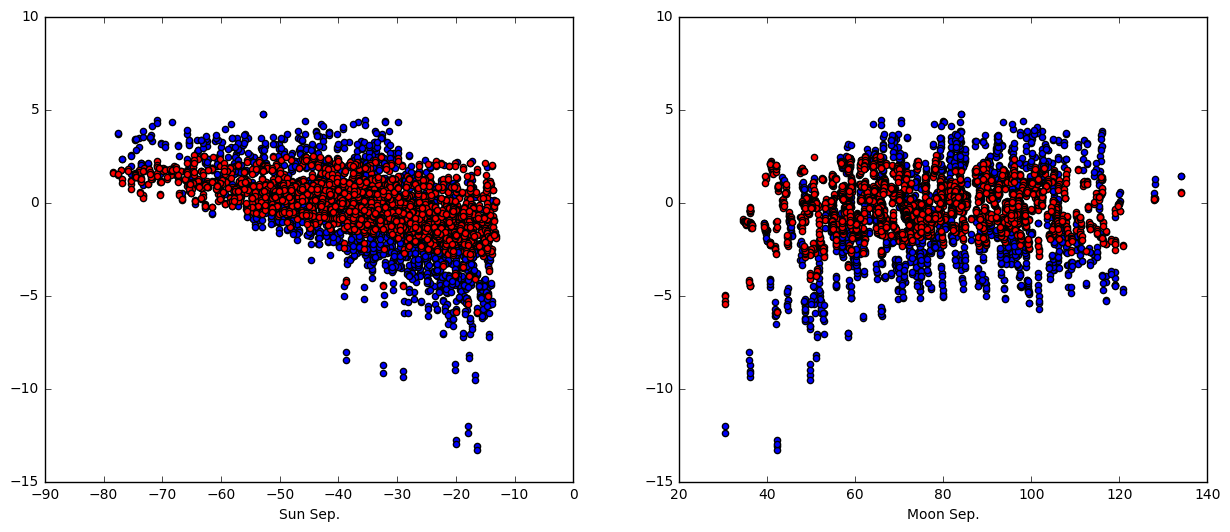

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,6))
db = data_dict_b['gray']
dr = data_dict_r['gray']
ax1.scatter(db['SUN_ALT'], gray_res_b, c = 'b')
ax1.scatter(dr['SUN_ALT'], gray_res_r, c = 'r')
ax1.set_xlabel("Sun Sep.")
ax2.scatter(db['MOON_SEP'], gray_res_b, c = 'b')
ax2.scatter(dr['MOON_SEP'], gray_res_r, c = 'r')
ax2.set_xlabel("Moon Sep.")

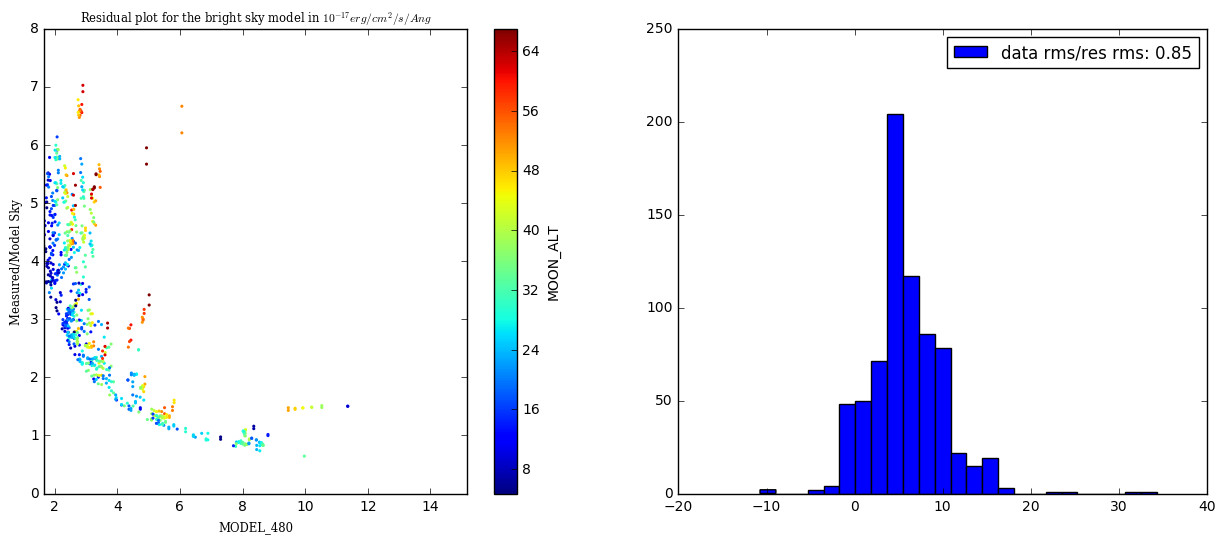

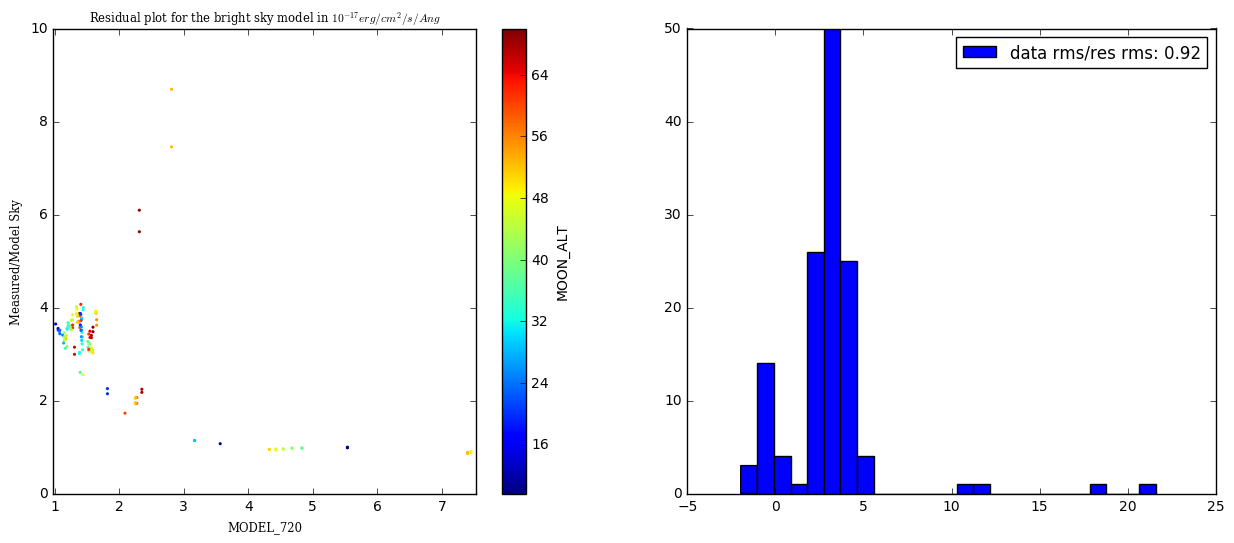

In [105]:
res = model_residuals(480, data_dict_b['bright'],'bright')
res = model_residuals(720, data_dict_r['bright'],'bright')

## Twilight Data

[0.93832994543737236, 0.12421612120904542, -0.020234806836623275, 0.0037242601314661072]
[0.53735261562846981, -0.0052222614981483288, 0.0094712049299614295, -0.0014486910993189326]


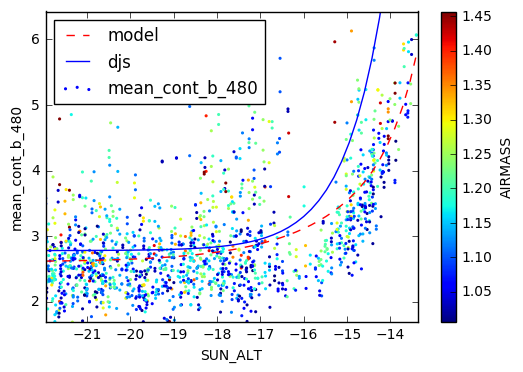

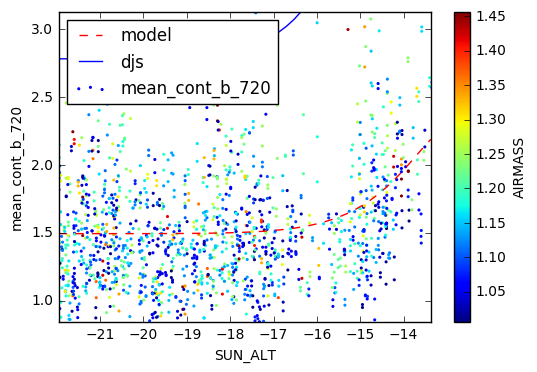

In [84]:
def plot_twilight(line, data, xname='SUN_ALT', vname='AIRMASS'):
    if line < 650:
        data = data[(data['CAMERAS'] == 'b1')|(data['CAMERAS'] == 'b2')]
    elif line >= 650:
        data = data[(data['CAMERAS'] == 'r1')|(data['CAMERAS'] == 'r2')]
        
    x = data[xname]
    yname = 'mean_cont_b_%d'%line
    y = data[yname]
    v = data[vname]
    VALID = np.isfinite(x) & np.isfinite(y)
    SEL = VALID & (data['SUN_ALT'] > -22) & (data['MOON_ALT'] < -5) 
    xmin, xmax = np.percentile(x[SEL], (1, 99))
    ymin, ymax = np.percentile(y[SEL], (1, 99))
    vmin, vmax = np.percentile(v[SEL], (1, 99))
    
    fig, ax = plt.subplots(1, figsize=(6,4))
    #ax = ax.flatten()

    s = ax.scatter(x[SEL], y[SEL], s=5, lw=0, c=v[SEL], vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax).set_label(vname)
    
    x_model = np.linspace(xmin, xmax, 50)
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    dark_sky = 2.78 #10^-17 erg/cm2/s/A
    getX = lambda x: np.vstack((dark_sky + 0*x, 2. ** (18.5 + x), 3. ** (18.5 + x),
                                4. ** (18.5 + x))).transpose()
    model.fit(getX(x[SEL]), y[SEL])
    print(list(model.coef_))
    y_model = model.predict(getX(x_model))
    ax.plot(x_model, y_model, 'r--',label='model')
    
    y_djs = dark_sky + 3 ** (18.5 + x_model) / 30.
    ax.plot(x_model, y_djs, 'b-', label='djs')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.legend(loc='upper left')

plot_twilight(480, data_dict_b['good'])
plot_twilight(720,data_dict_r['good'])